In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
PATH = '/home/hasser/semestre_7/model_gener/simpsons_face_detector/'

# GET FRAMES

In [19]:
#images = []
#cap = cv2.VideoCapture(PATH + 'simpson_faces/')
#frame_rate = 30
#rate = 0
"""
while cap.isOpened():
    rate +=1
    ret, frame = cap.read()
    if not ret:
        break
    if not rate % frame_rate == 0:
        continue
    images.append(frame)"""

'\nwhile cap.isOpened():\n    rate +=1\n    ret, frame = cap.read()\n    if not ret:\n        break\n    if not rate % frame_rate == 0:\n        continue\n    images.append(frame)'

# CONSTANTS

In [20]:
AREA = 4
lower_area_white = 50
upper_area_white = 40000
lower_area_yellow = 100
upper_area_yellow = 40000
k_size_blur = 5
k_size_color = 9
connect = 4
sensitivity_white = 50
sensitivity_black = 100

lower_yellow = np.array([22, 150, 120], dtype="uint16")
upper_yellow = np.array([50, 255, 255], dtype="uint16")

lower_white = np.array([0,0,255-sensitivity_white], dtype="uint16")
upper_white = np.array([255,sensitivity_white,255], dtype="uint16")

lower_black = np.array([0,0,0], dtype="uint16")
upper_black = np.array([255,255,sensitivity_black], dtype="uint16")
# 60 
image = cv2.imread(PATH + "sample/bart.png")

# PASO 1 OBTENER RGB, BLURRED, HSV, GRAY, CANNY

In [21]:
rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(rgb,cv2.COLOR_RGB2GRAY)
blurred = cv2.medianBlur(rgb, k_size_blur)
hsv = cv2.cvtColor(blurred, cv2.COLOR_RGB2HSV)
mask_black = cv2.inRange(hsv, lower_black, upper_black)
mask_black_copy = mask_black.copy()
height, width = mask_black_copy.shape
r = 1
for i in range(height):
    for j in range(width):
        try:
            if (mask_black[i-r:i+r+1, j-r:j+r+1]==255).any():
                mask_black_copy[i,j] = 255
            else:
                mask_black_copy[i,j] = 0
        except IndexError as e:
            mask_black_copy[i,j] = 0
mask_black = mask_black_copy

# PASO 2 FILTRAR, DESVANECER Y DIVIDIR CON CANNY LOS COLORES BLANCO Y AMARILLO

In [22]:
#YELLOW
mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)
blurred_yellow = cv2.medianBlur(mask_yellow, k_size_color)
yellow_minus_black = np.where(mask_black==255, 0, blurred_yellow)
#WHITE
mask_white = cv2.inRange(hsv, lower_white, upper_white)
blurred_white = cv2.medianBlur(mask_white, k_size_color)
white_minus_black = np.where(mask_black==255, 0, blurred_white)


# PASO 3 OBTENER LOS COMPONENTES BLANCOS Y AMARILLO

In [23]:
n_white_comp, white_masks, white_stats, white_centroids = cv2.connectedComponentsWithStats(white_minus_black, connectivity=connect)
n_yellow_comp, yellow_masks, yellow_stats, yellow_centroids = cv2.connectedComponentsWithStats(yellow_minus_black, connectivity=connect)

# PASO 4 FILTRAR LOS COMPONENTES POR SU TAMAÑO DE AREA

In [24]:
#WHITE
white_indexes = [comp_index for comp_index in range(n_white_comp)
                if white_stats[comp_index, AREA] >= lower_area_white and 
                white_stats[comp_index, AREA] <= upper_area_white]
white_comp_filt = np.where(white_masks==white_indexes[0], 255, 0)
for index in white_indexes[1:]:
    white_comp_filt += np.where(white_masks==index, 255, 0)
#YELLOW
yellow_indexes = [comp_index for comp_index in range(n_yellow_comp)
                if yellow_stats[comp_index, AREA] >= lower_area_yellow and 
                yellow_stats[comp_index, AREA] <= upper_area_yellow]
yellow_comp_filt = np.where(yellow_masks==yellow_indexes[0], 255, 0)
for index in yellow_indexes[1:]:
    yellow_comp_filt += np.where(yellow_masks==index, 255, 0)

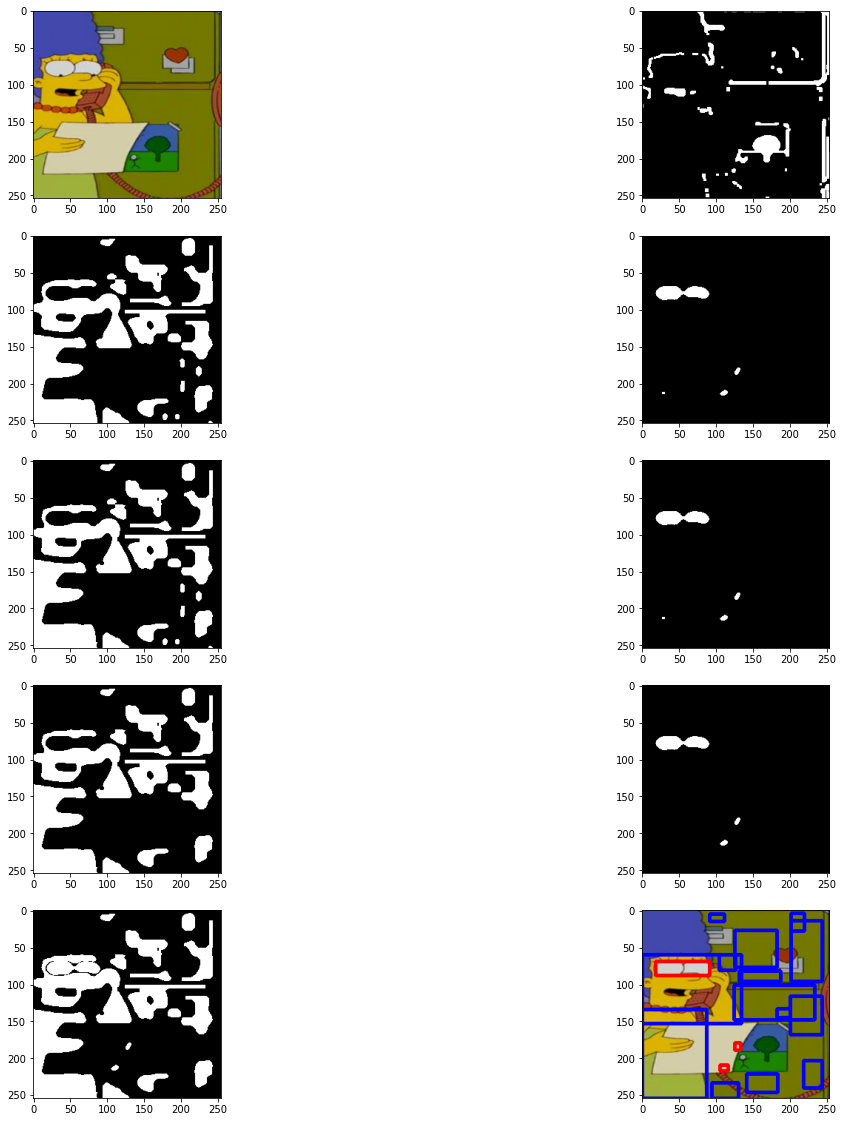

In [25]:
white_yellow = yellow_comp_filt + white_comp_filt
white_yellow = np.where(white_yellow>=255,255,0)
boxed = rgb.copy()
for x,y,w,h,a in white_stats[white_indexes]:
    cv2.rectangle(boxed, pt1=(x,y), pt2=(x+w,y+h), color=(255,0,0), thickness=4)
for x,y,w,h,a in yellow_stats[yellow_indexes]:
    cv2.rectangle(boxed, pt1=(x,y), pt2=(x+w,y+h), color=(0,0,255), thickness=4)

faces = []
for yellow_box in yellow_stats[yellow_indexes]:
    n_white_boxes = 0
    x,y,width,height,area = yellow_box
    y_x1, y_x2, y_y1, y_y2 = x, x+width, y, y+height
    for white_box in white_stats[white_indexes]:
        x,y,width,height,area = white_box
        w_x1, w_x2, w_y1, w_y2 = x, x+width, y, y+height
        # If white box contained in yellow box
        if w_x1 >= y_x1 and w_x2 <= y_x2 and y_y1 <= w_y1 and y_y2 >= w_y2:
            n_white_boxes +=1
    if n_white_boxes <= 2 and n_white_boxes >= 1:
        faces.append(yellow_box)



fig, axs = plt.subplots(5,2, figsize=(20,20))
axs[0,0].imshow(rgb)
axs[0,1].imshow(mask_black, cmap='gray')

axs[1,0].imshow(blurred_yellow,cmap='gray')
axs[2,0].imshow(yellow_minus_black,cmap='gray')
axs[3,0].imshow(yellow_comp_filt, cmap='gray')

axs[1,1].imshow(blurred_white,cmap='gray')
axs[2,1].imshow(white_minus_black,cmap='gray')
axs[3,1].imshow(white_comp_filt, cmap='gray')

axs[4,0].imshow(white_yellow, cmap='gray')
axs[4,1].imshow(boxed)

